# Congressional Sentiment Analysis EDA and Data Cleaning

1. [Section 1: Setup and Data Import](#section-1-setup-and-data-import)
    * [1.1 Library Imports and Environment Setup](#11-library-imports-and-environment-setup)
    * [1.2 Loading and Merging Speech Data](#12-loading-and-merging-speech-data)
    * [1.3 Initial Data Inspection](#13-initial-data-inspection)

2. [Section 2: Data Cleaning and Standardization](#section-2-data-cleaning-and-standardization)
    * [2.1 Column Selection and Basic Transformations](#21-column-selection-and-basic-transformations)
    * [2.2 Type Conversion and ID Standardization](#22-type-conversion-and-id-standardization)
    * [2.3 Cleaning and Harmonizing Categorical Variables](#23-cleaning-and-harmonizing-categorical-variables)
    * [2.4 Missing Data Inspection](#24-missing-data-inspection)


3. [Section 3: Exploratory Data Analysis (EDA)](#section-3-exploratory-data-analysis-eda)
    * [3.1 Frequency Distributions](#31-frequency-distributions)
    * [3.2 Topic and Party Relationships](#32-topic-and-party-relationships)
    * [3.3 Correlation Analysis of Numeric Features](#33-correlation-analysis-of-numeric-features)
    * [3.5 Temporal Trends in Speech Activity](#35-temporal-trends-in-speech-activity)
    * [3.6 Speech Length and Speaker Characteristics](#36-speech-length-and-speaker-characteristics)

4. [Section 4: Modeling Preparation – Toward a Polarization Metric](#section-4-modeling-preparation--toward-a-polarization-metric)
    * [4.1 Exporting the Modeling Dataset](#41-exporting-the-modeling-dataset)


# Section 1: Setup and Data Import
<a name="section-1-setup-and-data-import"></a>

## 1.1 Library Imports and Environment Setup
<a name="11-library-imports-and-environment-setup"></a>

In [1]:
from google.colab import drive
import pandas as pd
import os, glob, re
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from matplotlib.patches import Patch

## 1.2 Loading and Merging Speech Data
<a name="12-loading-and-merging-speech-data"></a>

In [2]:
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/Congress Data'

rx = re.compile(r'^speeches_(\d+)_clean\.csv$', re.IGNORECASE)
candidates = glob.glob(os.path.join(folder, 'speeches_*_clean.csv'))

matched, skipped = [], []
for f in candidates:
    m = rx.search(os.path.basename(f))
    if m:
        matched.append((f, int(m.group(1))))
    else:
        skipped.append(f)

matched.sort(key=lambda t: t[1])
files = [f for f, _ in matched]

print(f"Found {len(files)} matching files.")
if skipped:
    print("Skipped non-matching files:", [os.path.basename(s) for s in skipped])

if not files:
    raise FileNotFoundError("No files matched pattern speeches_<digits>_clean.csv")

dfs = []
for f in files:
    m = rx.search(os.path.basename(f))
    congress_num = int(m.group(1))
    df = pd.read_csv(f)
    df['congress'] = congress_num
    df['source_file'] = os.path.basename(f)
    dfs.append(df)

all_speeches = pd.concat(dfs, ignore_index=True)

out_path = os.path.join(folder, 'speeches_all_clean.csv')
all_speeches.to_csv(out_path, index=False)

#big_merged_path = os.path.join(folder, 'all_speeches.csv')
#all_speeches.to_csv(big_merged_path, index=False)
#print(f"Also saved merged data as: {big_merged_path}")

print(f"Loaded {len(files)} files into one table with {len(all_speeches):,} rows.")

Mounted at /content/drive
Found 13 matching files.
Skipped non-matching files: ['speeches_all_clean.csv']
Loaded 13 files into one table with 984,929 rows.


## 1.3 Initial Data Inspection
<a name="13-initial-data-inspection"></a>

In [3]:
all_speeches.head()


,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,...,char_count,word_count,speakerid,party,district,nonvoting,congress,topic,speaker_age,source_file
0,1070000002,Mr. President. on behalf of the entire Senate....,S,2001-01-03,2,Thomas Daschle,Thomas,Daschle,SD,M,...,2346,444,107112401.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv
1,1070000005,I appreciate the courtesy of the distinguished...,S,2001-01-03,5,Trent Lott,Trent,Lott,MS,M,...,307,52,107115011.0,R,NaN,voting,107,other,NaN,speeches_107_clean.csv
2,1070000007,It is obvious. Mr. President. you still mainta...,S,2001-01-03,7,Trent Lott,Trent,Lott,MS,M,...,288,53,107115011.0,R,NaN,voting,107,other,NaN,speeches_107_clean.csv
3,1070000014,respectively. advanced to the desk of the Vice...,S,2001-01-03,14,Robert Torricelli,Robert,Torricelli,NJ,M,...,201,34,107112221.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv
4,1070000017,respectively. advanced to the desk of the Vice...,S,2001-01-03,17,Barbara Boxer,Barbara,Boxer,CA,F,...,201,34,107118701.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv


In [4]:
print(all_speeches.dtypes)
print(all_speeches.info())
print(all_speeches.describe(include='all'))

speech_id              object
speech                 object
chamber                object
date                   object
number_within_file      int64
speaker                object
first_name             object
last_name              object
state                  object
gender                 object
line_start            float64
line_end              float64
file                   object
char_count              int64
word_count              int64
speakerid             float64
party                  object
district              float64
nonvoting              object
congress                int64
topic                  object
speaker_age           float64
source_file            object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984929 entries, 0 to 984928
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   speech_id           984929 non-null  object 
 1   speech              984929 non

# Section 2: Data Cleaning and Standardization
<a name="section-2-data-cleaning-and-standardization"></a>

## 2.1 Column Selection and Basic Transformations
<a name="21-column-selection-and-basic-transformations"></a>

In [5]:
#all_speeches = all_speeches.drop(columns=['speech'], errors='ignore')

#all_speeches['full_name'] = (
#    all_speeches['first_name'].fillna('').astype(str).str.strip()
#    .str.cat(all_speeches['last_name'].fillna('').astype(str).str.strip(), sep=' ')
#    .str.replace(r'\s+', ' ', regex=True).str.strip()
#)

# Remove original name columns
all_speeches = all_speeches.drop(columns=['first_name', 'last_name', 'full_name'], errors='ignore')
all_speeches

,speech_id,speech,chamber,date,number_within_file,speaker,state,gender,line_start,line_end,...,char_count,word_count,speakerid,party,district,nonvoting,congress,topic,speaker_age,source_file
0,1070000002,Mr. President. on behalf of the entire Senate....,S,2001-01-03,2,Thomas Daschle,SD,M,81.0,147.0,...,2346,444,107112401.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv
1,1070000005,I appreciate the courtesy of the distinguished...,S,2001-01-03,5,Trent Lott,MS,M,154.0,178.0,...,307,52,107115011.0,R,NaN,voting,107,other,NaN,speeches_107_clean.csv
2,1070000007,It is obvious. Mr. President. you still mainta...,S,2001-01-03,7,Trent Lott,MS,M,183.0,190.0,...,288,53,107115011.0,R,NaN,voting,107,other,NaN,speeches_107_clean.csv
3,1070000014,respectively. advanced to the desk of the Vice...,S,2001-01-03,14,Robert Torricelli,NJ,M,1104.0,1109.0,...,201,34,107112221.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv
4,1070000017,respectively. advanced to the desk of the Vice...,S,2001-01-03,17,Barbara Boxer,CA,F,1120.0,1125.0,...,201,34,107118701.0,D,NaN,voting,107,other,NaN,speeches_107_clean.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984924,CREC-2025-08-01-pt1-PgS5189_276,"Mr. THUNE. Mr. President, I want to just congr...",Senate,2025-08-01,78,John Thune,SD,M,NaN,NaN,...,814,140,NaN,R,NaN,False,119,other,64.0,speeches_119_clean.csv
984925,CREC-2025-08-01-pt1-PgS5475-7_0,"Mr. THUNE. Mr. President, I ask unanimous cons...",Senate,2025-08-01,1,John Thune,SD,M,NaN,NaN,...,194,30,NaN,R,NaN,False,119,other,64.0,speeches_119_clean.csv
984926,CREC-2025-08-01-pt1-PgS5475-7_4,"Mr. THUNE. Mr. President, I ask unanimous cons...",Senate,2025-08-01,2,John Thune,SD,M,NaN,NaN,...,267,47,NaN,R,NaN,False,119,other,64.0,speeches_119_clean.csv
984927,CREC-2025-08-01-pt1-PgS5201-3_0,"Mr. DURBIN. Mr. President, I was necessarily a...",Senate,2025-08-01,1,Richard Durbin,IL,M,NaN,NaN,...,511,86,NaN,D,NaN,False,119,other,80.0,speeches_119_clean.csv


## 2.2 Type Conversion and ID Standardization
<a name="22-type-conversion-and-id-standardization"></a>


In [6]:
all_speeches['date'] = pd.to_datetime(all_speeches['date'], errors='coerce')
all_speeches['speech_id'] = all_speeches['speech_id'].astype(str)

exclude = {'speech', 'file', 'speech_id', 'date', 'speaker'}

categorical_threshold = 10

categorical_variables = [
    col for col in all_speeches.columns
    if col not in exclude and (
        all_speeches[col].dtype == 'object'
        or (all_speeches[col].dtype in ['int64', 'float64']
            and all_speeches[col].nunique() <= categorical_threshold)
    )
]

unique_values = {col: all_speeches[col].unique() for col in categorical_variables}

for col, values in unique_values.items():
    print(f"Unique values for {col}: {values}")

print("Number of scanned columns:", len(categorical_variables))


Unique values for chamber: ['S' 'H' 'Senate' 'House']
Unique values for state: ['SD' 'MS' 'NJ' 'CA' 'CT' 'FL' 'ME' 'NV' 'IL' 'GA' 'WA' 'IN' 'SC' 'MD'
 'OK' 'TX' 'MO' 'MI' 'MA' 'DE' 'LA' 'DC' 'OH' 'NY' 'CO' 'VT' 'ND' 'ID'
 'NM' 'AK' 'WV' 'KS' 'UT' 'VA' 'AZ' 'AR' 'WY' 'PA' 'HI' 'NC' 'IA' 'MT'
 'NH' 'NE' 'MN' 'WI' 'KY' 'AL' 'TN' 'OR' 'RI' 'GU' 'VI' 'PR' 'AS' 'MP']
Unique values for gender: ['M' 'F']
Unique values for party: ['D' 'R' 'I' 'A' 'P' 'Libertarian']
Unique values for nonvoting: ['voting' 'nonvoting' False]
Unique values for topic: ['other' 'crime' 'health' 'federalism' 'education' 'budget' 'government'
 'justice' 'elections' 'tax' 'labor' 'defense' 'minorities' 'foreign'
 'trade' 'business' 'religion' 'immigration' 'money' 'environment'
 'economy' 'mail' 'alcohol']
Unique values for source_file: ['speeches_107_clean.csv' 'speeches_108_clean.csv'
 'speeches_109_clean.csv' 'speeches_110_clean.csv'
 'speeches_111_clean.csv' 'speeches_112_clean.csv'
 'speeches_113_clean.csv' 'speech

## 2.3 Cleaning and Harmonizing Categorical Variables
<a name="23-cleaning-and-harmonizing-categorical-variables"></a>

In [7]:
all_speeches['chamber'] = (
    all_speeches['chamber'].astype(str).str.strip().str.lower()
      .replace({'s': 'senate', 'h': 'house'})
      .replace({'senate': 'Senate', 'house': 'House'})
).astype(str)

state_map = {
    'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado',
    'CT':'Connecticut','DE':'Delaware','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho',
    'IL':'Illinois','IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan','MN':'Minnesota',
    'MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada',
    'NH':'New Hampshire','NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina',
    'ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas',
    'UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington','WV':'West Virginia',
    'WI':'Wisconsin','WY':'Wyoming',
    # District & territories
    'DC':'District of Columbia','PR':'Puerto Rico','GU':'Guam','VI':'U.S. Virgin Islands',
    'AS':'American Samoa','MP':'Northern Mariana Islands',
}
all_speeches['state_abbrev'] = all_speeches['state']
all_speeches['state'] = (
    all_speeches['state'].astype(str).str.strip().str.upper().map(state_map)
      .fillna(all_speeches['state'])
).astype(str)

gender_map = {'M': 'Male', 'F': 'Female'}
all_speeches['gender'] = (
    all_speeches['gender'].astype(str).str.strip().str.upper().map(gender_map)
      .fillna(all_speeches['gender'])
).astype(str)

party_map = {
    'D': 'Democratic',
    'R': 'Republican',
    'I': 'Independent',
    'LIBERTARIAN': 'Libertarian',
    'A': 'American/Other',
    'P': 'Progressive/Popular Democratic'
}
party_norm = all_speeches['party'].astype(str).str.strip()
all_speeches['party'] = (
    party_norm.str.upper().map(party_map).fillna(party_norm)
).astype(str)

print("Unique chamber values:", sorted(pd.Series(all_speeches['chamber'].unique()).astype(str)))
print("Unique gender values:", sorted(pd.Series(all_speeches['gender'].unique()).astype(str)))
print("Unique party values:", sorted(pd.Series(all_speeches['party'].unique()).astype(str))[:20])
print("Unique state sample:", sorted(pd.Series(all_speeches['state'].dropna().unique()).astype(str))[:15])
#all_speeches

Unique chamber values: ['House', 'Senate']
Unique gender values: ['Female', 'Male']
Unique party values: ['American/Other', 'Democratic', 'Independent', 'Libertarian', 'Progressive/Popular Democratic', 'Republican']
Unique state sample: ['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho']


In [8]:

all_speeches['date'] = pd.to_datetime(all_speeches['date'], errors='coerce')
all_speeches['speech_id'] = all_speeches['speech_id'].astype(str)

exclude = {'speech', 'file', 'speech_id', 'date', 'speaker', 'full_name'}

categorical_threshold = 10

categorical_variables = [
    col for col in all_speeches.columns
    if col not in exclude and (
        all_speeches[col].dtype == 'object'
        or (all_speeches[col].dtype in ['int64', 'float64']
            and all_speeches[col].nunique() <= categorical_threshold)
    )
]

unique_values = {col: all_speeches[col].unique() for col in categorical_variables}

for col, values in unique_values.items():
    print(f"Unique values for {col}: {values}")

print("Number of scanned columns:", len(categorical_variables))
#all_speeches

Unique values for chamber: ['Senate' 'House']
Unique values for state: ['South Dakota' 'Mississippi' 'New Jersey' 'California' 'Connecticut'
 'Florida' 'Maine' 'Nevada' 'Illinois' 'Georgia' 'Washington' 'Indiana'
 'South Carolina' 'Maryland' 'Oklahoma' 'Texas' 'Missouri' 'Michigan'
 'Massachusetts' 'Delaware' 'Louisiana' 'District of Columbia' 'Ohio'
 'New York' 'Colorado' 'Vermont' 'North Dakota' 'Idaho' 'New Mexico'
 'Alaska' 'West Virginia' 'Kansas' 'Utah' 'Virginia' 'Arizona' 'Arkansas'
 'Wyoming' 'Pennsylvania' 'Hawaii' 'North Carolina' 'Iowa' 'Montana'
 'New Hampshire' 'Nebraska' 'Minnesota' 'Wisconsin' 'Kentucky' 'Alabama'
 'Tennessee' 'Oregon' 'Rhode Island' 'Guam' 'U.S. Virgin Islands'
 'Puerto Rico' 'American Samoa' 'Northern Mariana Islands']
Unique values for gender: ['Male' 'Female']
Unique values for party: ['Democratic' 'Republican' 'Independent' 'American/Other'
 'Progressive/Popular Democratic' 'Libertarian']
Unique values for nonvoting: ['voting' 'nonvoting' False]
Un

## 2.4 Missing Data Inspection
<a name="24-missing-data-inspection"></a>

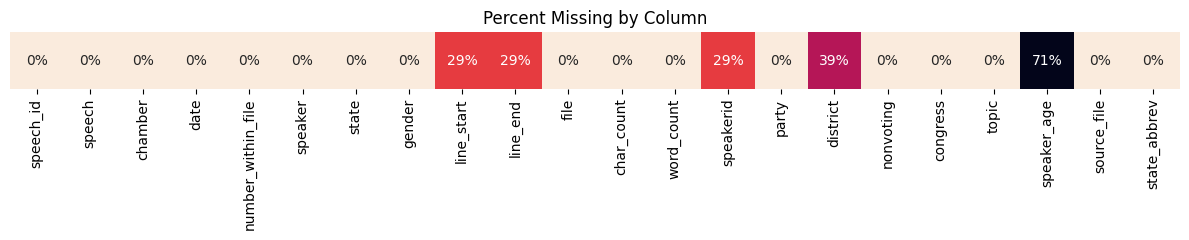

In [9]:
missing_pct = all_speeches.isna().mean().to_frame('% missing').T
plt.figure(figsize=(12,2.5))
sns.heatmap(missing_pct, annot=True, fmt=".0%", cbar=False, cmap='rocket_r')
plt.title('Percent Missing by Column')
plt.yticks([])
plt.tight_layout()
plt.show()


# Section 3: Exploratory Data Analysis (EDA)
<a name="section-3-exploratory-data-analysis-eda"></a>


## 3.1 Frequency Distributions for the columns "state" and "party"
<a name="31-frequency-distributions"></a>


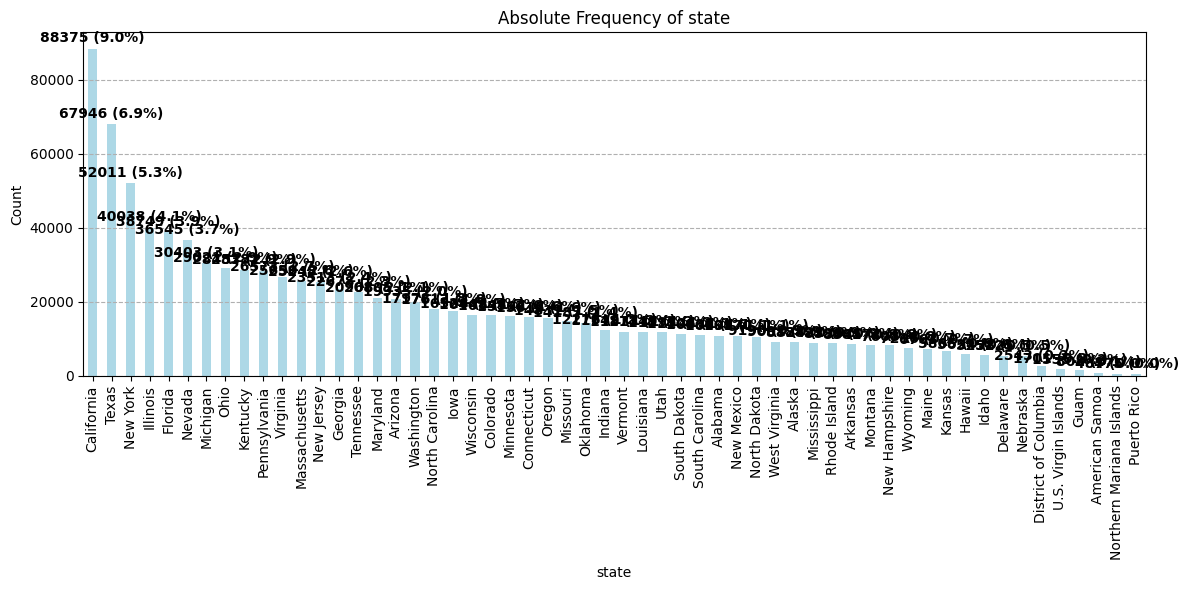

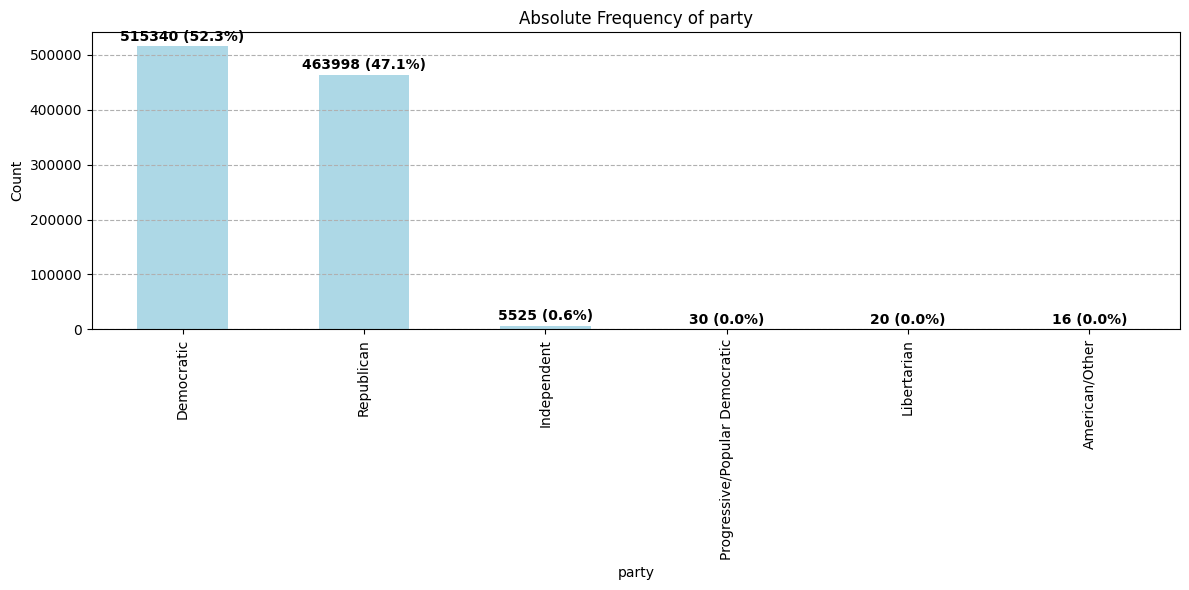

In [10]:
def plot_frequency(variable, title, data):
    abs_freq = data[variable].value_counts()
    rel_freq = data[variable].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))
    ax = abs_freq.plot(kind='bar', color='lightblue')
    plt.title(f'Absolute Frequency of {title}')
    plt.xlabel(title)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--')

    for i, (count, pct) in enumerate(zip(abs_freq, rel_freq)):
        label = f"{count} ({pct:.1f}%)"
        ax.text(
            i, count + (max(abs_freq) * 0.01),
            label, ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

plot_frequency('state', 'state', all_speeches)

plot_frequency('party', 'party', all_speeches)




## 3.2 Topic and Party Relationships
<a name="32-topic-and-party-relationships"></a>


topic
other          689429
health          51604
education       26125
defense         25799
justice         25130
federalism      24593
tax             22117
foreign         21198
labor           19973
business        16332
minorities      13076
budget          11411
government       7530
trade            7129
immigration      6684
crime            6556
elections        4162
money            2796
economy          1182
environment      1142
religion          474
mail              440
alcohol            47
Name: count, dtype: int64


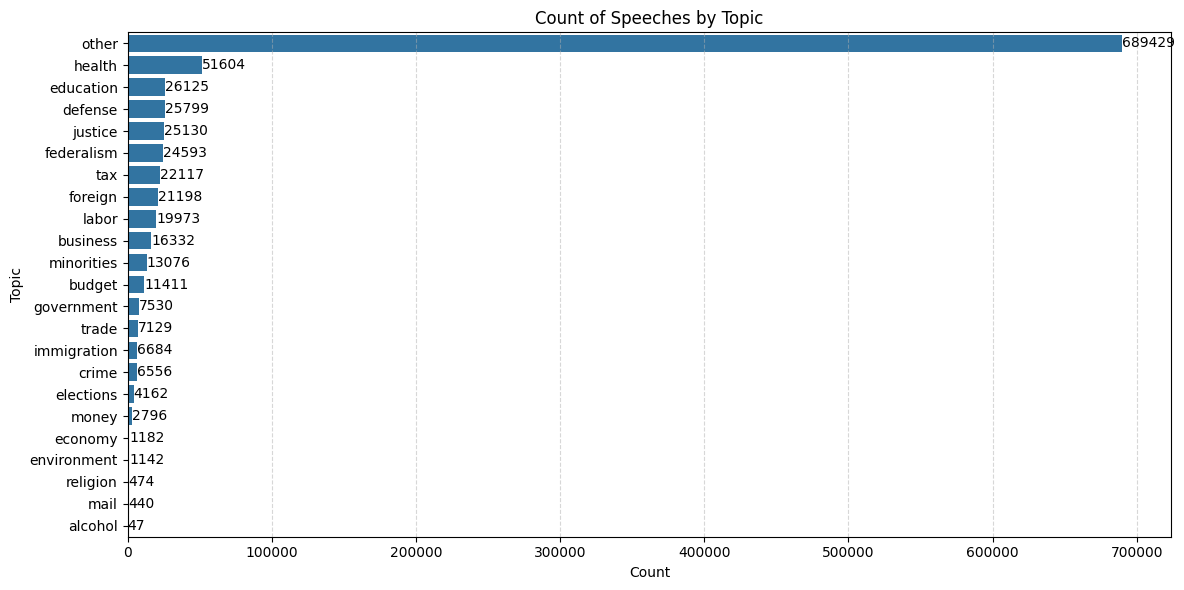

In [11]:
topic_counts = (
    all_speeches['topic']
    .fillna('Unknown')
    .value_counts()
    .sort_values(ascending=False)
)

print(topic_counts)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=topic_counts.values,
    y=topic_counts.index
)

plt.title('Count of Speeches by Topic')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

for i, value in enumerate(topic_counts.values):
    ax.text(
        value,
        i,
        f'{value}',
        va='center',
        ha='left',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 3.2.1 Topic distribution for Democratic and Republican Speeches

Topic counts (Democrats & Republicans only):
topic
other          685873
health          51179
education       25959
defense         25628
justice         24961
federalism      24437
tax             21953
foreign         21046
labor           19818
business        16226
minorities      13030
budget          11355
government       7469
trade            7075
immigration      6646
crime            6529
elections        4127
money            2786
economy          1177
environment      1125
religion          472
mail              421
alcohol            46
Name: count, dtype: int64


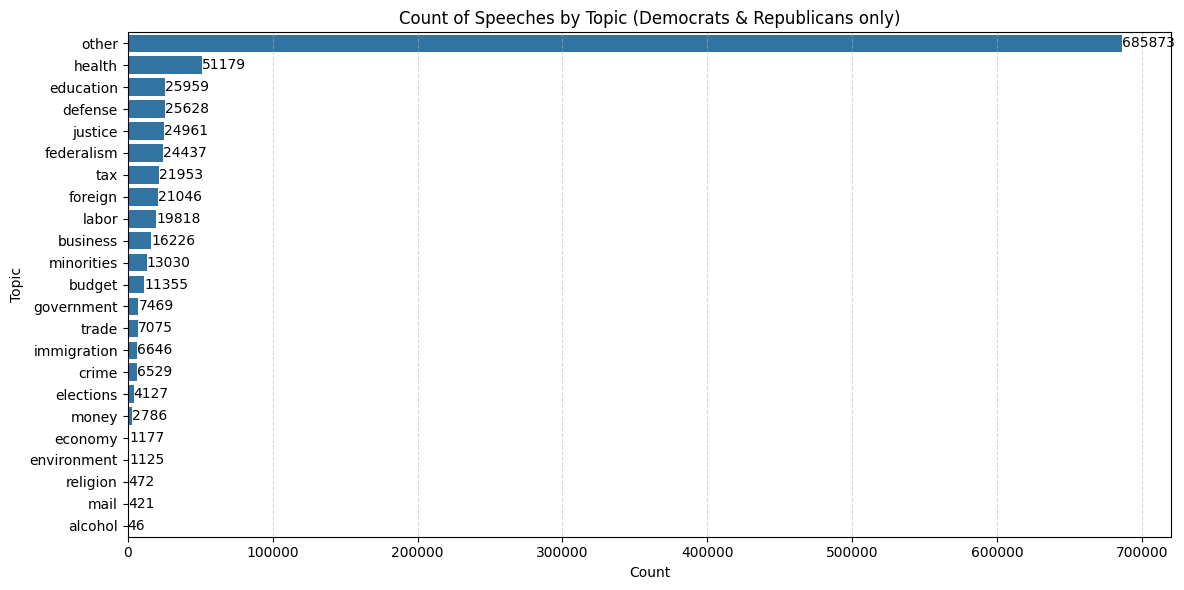

In [12]:
party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
mask = party_norm.isin(['d', 'r', 'democrat', 'democratic', 'republican', 'republicans', 'democrats'])

df_dr = all_speeches[mask].copy()

df_dr['party_clean'] = party_norm.loc[mask].map({
    'd':'Democratic', 'democrat':'Democratic', 'democrats':'Democratic', 'democratic':'Democratic',
    'r':'Republican', 'republican':'Republican', 'republicans':'Republican'
})

topic_counts = (
    df_dr['topic']
      .fillna('Unknown')
      .value_counts()
      .sort_values(ascending=False)
)

print("Topic counts (Democrats & Republicans only):")
print(topic_counts)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=topic_counts.values,
    y=topic_counts.index
)

plt.title('Count of Speeches by Topic (Democrats & Republicans only)')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

for i, value in enumerate(topic_counts.values):
    ax.text(
        value,
        i,
        f'{value}',
        va='center',
        ha='left',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 3.2.2 Topic distribution for Democratic and Republican Speeches (Excluding topic “Other”)



Topic counts (Democrats & Republicans only, excluding 'other'):
topic
health         51179
education      25959
defense        25628
justice        24961
federalism     24437
tax            21953
foreign        21046
labor          19818
business       16226
minorities     13030
budget         11355
government      7469
trade           7075
immigration     6646
crime           6529
elections       4127
money           2786
economy         1177
environment     1125
religion         472
mail             421
alcohol           46
Name: count, dtype: int64

TOTAL: 293465


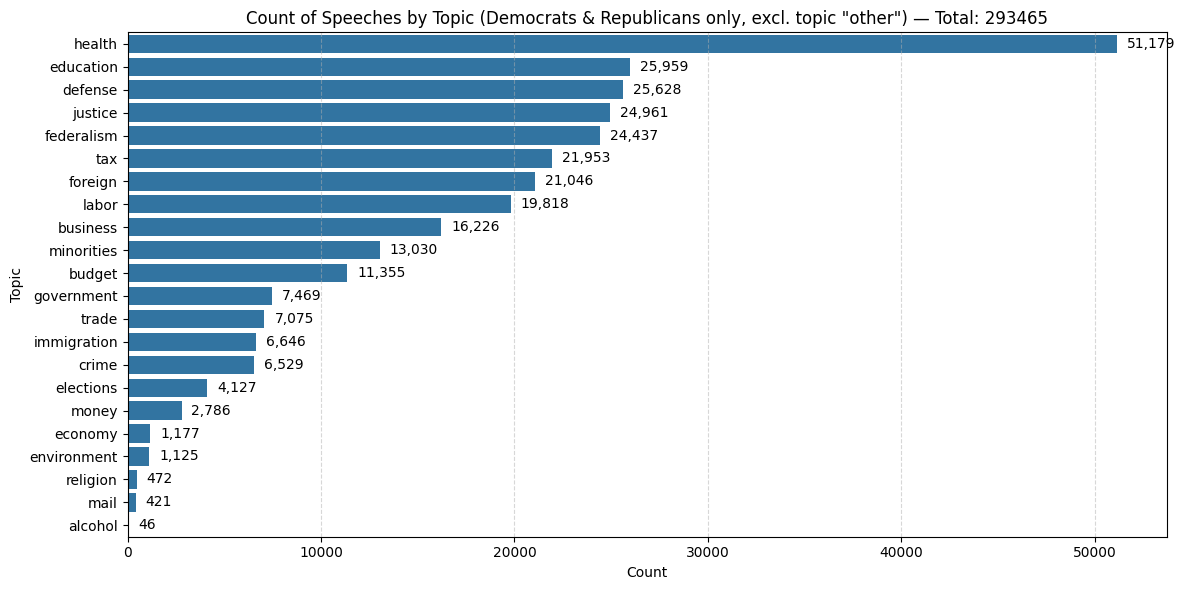

In [13]:
party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
mask_party = party_norm.isin(['d', 'r', 'democrat', 'democratic', 'republican', 'republicans', 'democrats'])
df_dr = all_speeches[mask_party].copy()

topic_series = df_dr['topic'].astype(str).str.strip()
mask_topic = topic_series.str.lower() != 'other'
topic_series = topic_series[mask_topic].replace('', pd.NA).fillna('Unknown')

topic_counts = topic_series.value_counts().sort_values(ascending=False)

total_topics = int(topic_counts.sum())
print("Topic counts (Democrats & Republicans only, excluding 'other'):")
print(topic_counts)
print("\nTOTAL:", total_topics)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=topic_counts.values, y=topic_counts.index)
plt.title(f'Count of Speeches by Topic (Democrats & Republicans only, excl. topic "other") — Total: {total_topics}')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + max(topic_counts.values) * 0.01,
            y,
            f"{int(width):,}",
            va='center',
            ha='left')

plt.tight_layout()
plt.show()


This section focuses on analyzing and visualizing the **distribution of topics** in speeches delivered by **Democratic** and **Republican** members only.  
It begins by filtering the dataset to keep rows where the `party` column corresponds to either party, handling different text variations (e.g., `"D"`, `"democrats"`, `"republicans"`).  
Next, it excludes any speeches labeled with the topic `"other"` and replaces missing or blank entries with `"Unknown"` to maintain completeness.  
The script then counts how many speeches fall under each topic and computes the **total number of included speeches**.  
Finally, it visualizes the topic frequencies using a **horizontal bar chart**, where each bar represents a topic and is annotated with its exact count for clear comparison.  
This allows for an immediate understanding of which topics dominate among speeches from the two main U.S. political parties.

### 3.2.3 Heatmap of Topic Distribution by Party (Excluding topic “Others”)

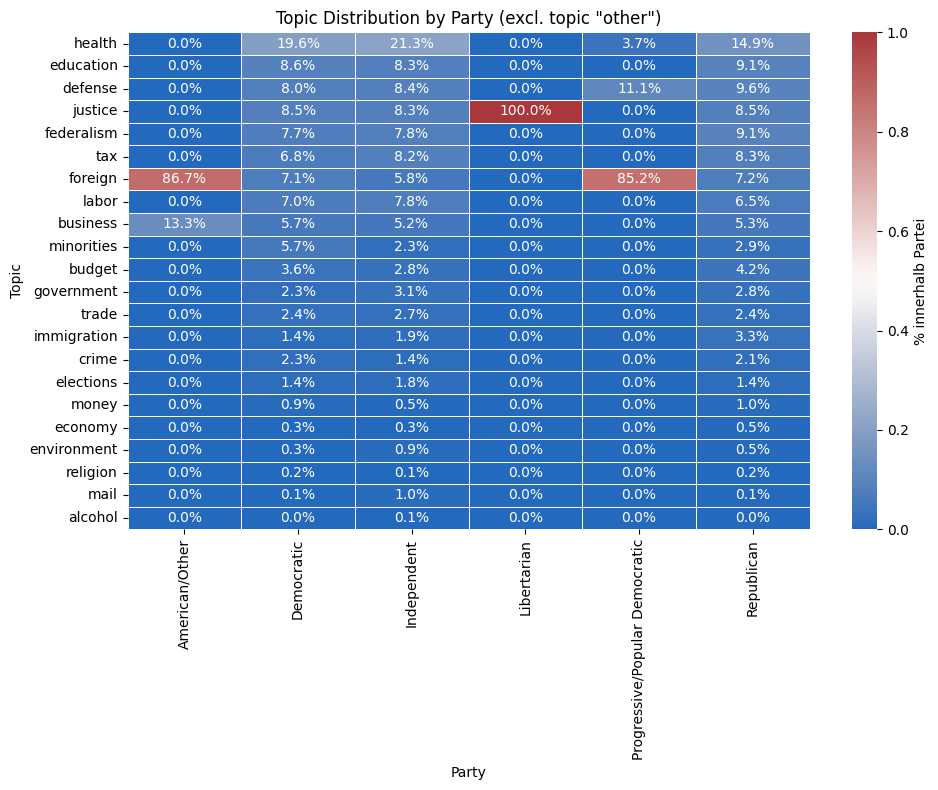

In [14]:
filtered = all_speeches[all_speeches['topic'].str.lower() != "other"]

ct = (filtered
      .assign(topic=filtered['topic'].fillna('Unknown'))
      .pivot_table(index='topic', columns='party', values='speaker', aggfunc='count', fill_value=0))

ct_norm = ct.div(ct.sum(axis=0), axis=1)

order = ct.sum(axis=1).sort_values(ascending=False).index
ct_norm = ct_norm.loc[order]

annot_labels = ct_norm.mul(100).round(1).astype(str) + "%"

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    ct_norm,
    cmap='vlag',
    linewidths=.5,
    annot=annot_labels,
    fmt="",
    cbar_kws={'label': '% innerhalb Partei'}
)
plt.title('Topic Distribution by Party (excl. topic "other")')
plt.xlabel('Party'); plt.ylabel('Topic')
plt.tight_layout()
plt.show()

### 3.2.4 Heatmap of Topic Distribution for Democrats and Republicans (Excluding topic "Others")

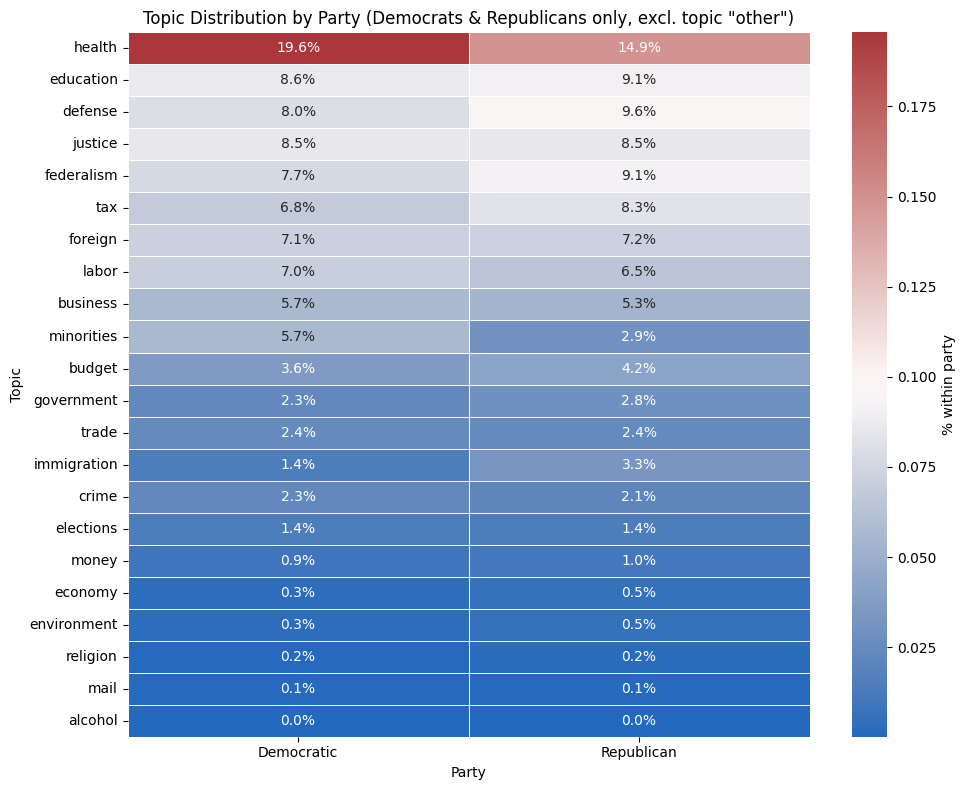

In [15]:
party_norm = (
    all_speeches['party']
    .astype(str)
    .str.strip()
    .str.lower()
)

party_map = {
    'd':'Democratic', 'democrat':'Democratic', 'democrats':'Democratic', 'democratic':'Democratic',
    'r':'Republican', 'republican':'Republican', 'republicans':'Republican'
}

df = all_speeches.copy()
df['party_clean'] = party_norm.map(party_map)
df = df[df['party_clean'].isin(['Democratic', 'Republican'])]

topic_norm = df['topic'].astype(str).str.strip()
df = df[topic_norm.str.lower() != 'other'].copy()
df['topic'] = topic_norm.fillna('Unknown')

ct = (
    df.pivot_table(index='topic', columns='party_clean', values='speaker',
                   aggfunc='count', fill_value=0)
      .reindex(columns=['Democratic', 'Republican'])
      .fillna(0)
)

col_sums = ct.sum(axis=0).replace(0, np.nan)
ct_norm = ct.div(col_sums, axis=1)

order = ct.sum(axis=1).sort_values(ascending=False).index
ct_norm = ct_norm.loc[order]

annot_labels = (ct_norm * 100).round(1).astype(str) + "%"

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    ct_norm,
    cmap='vlag',
    linewidths=.5,
    annot=annot_labels,
    fmt="",
    cbar_kws={'label': '% within party'}
)
plt.title('Topic Distribution by Party (Democrats & Republicans only, excl. topic "other")')
plt.xlabel('Party'); plt.ylabel('Topic')
plt.tight_layout()
plt.show()


## 3.3 Correlation Analysis of Numeric Features
<a name="33-correlation-analysis-of-numeric-features"></a>

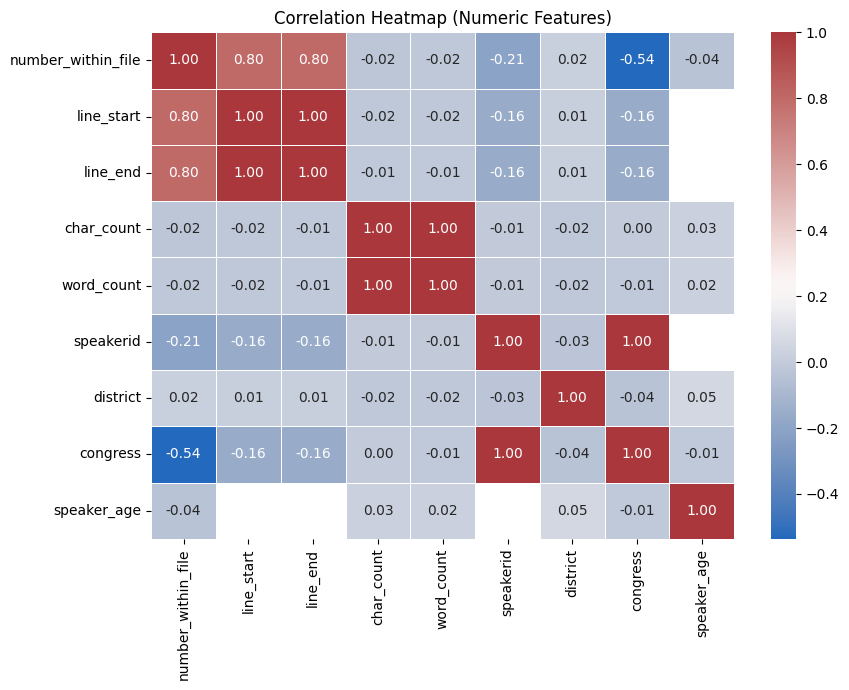

In [16]:
num_cols = all_speeches.select_dtypes(include=['number']).columns
plt.figure(figsize=(9,7))
sns.heatmap(all_speeches[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag', linewidths=.5)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()


## 3.5 Temporal Trends in Speech Activity
<a name="35-temporal-trends-in-speech-activity"></a>

### 3.5.1 Speech Activity with topic "Others"

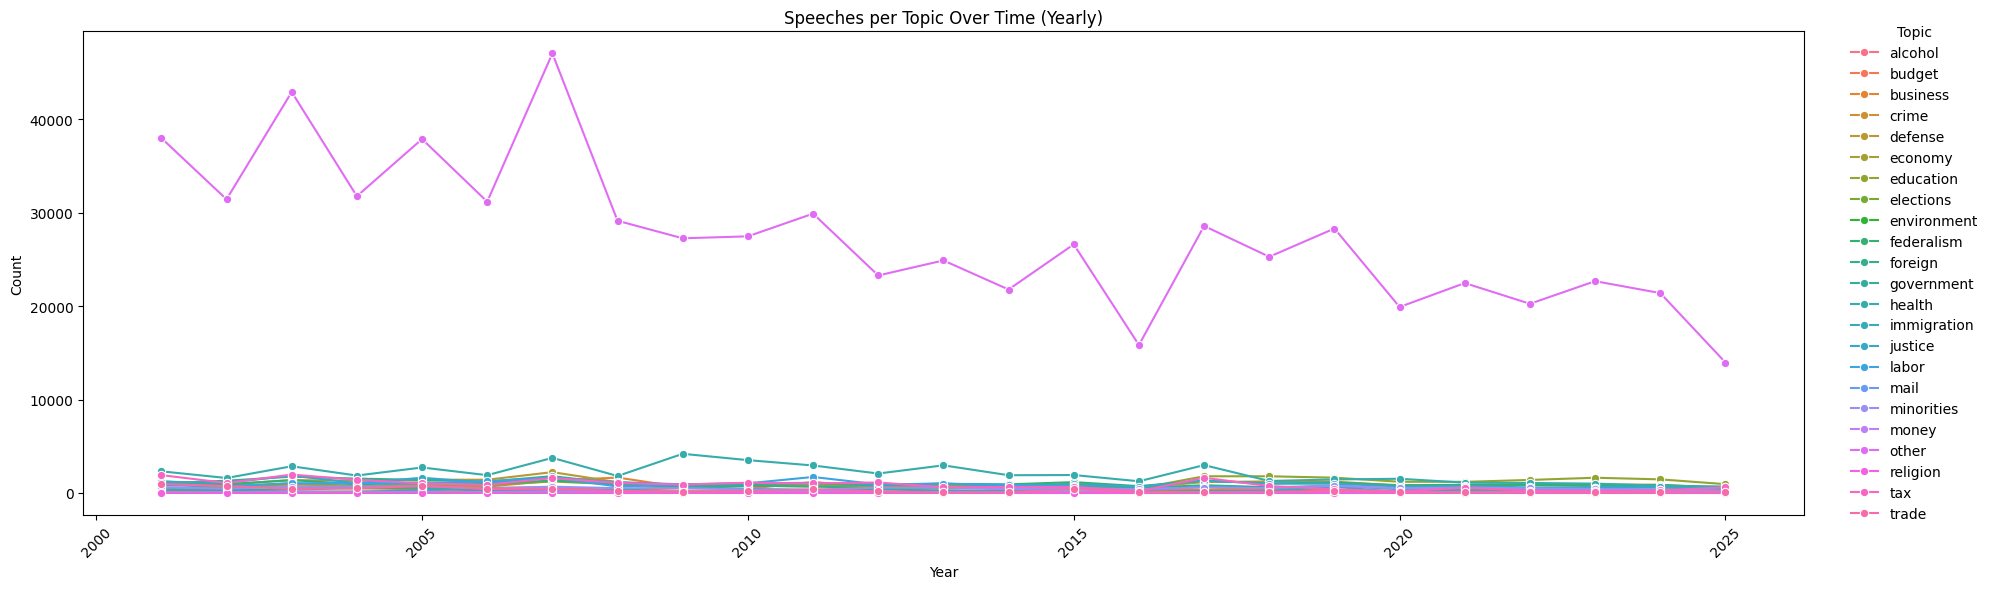

In [17]:
all_speeches['date'] = pd.to_datetime(all_speeches['date'], errors='coerce')
all_speeches['year'] = all_speeches['date'].dt.year

topic_year = (
    all_speeches
      .dropna(subset=['year'])
      .assign(topic=lambda d: d['topic'].fillna('Unknown'))
      .groupby(['year', 'topic'])
      .size()
      .reset_index(name='count')
      .sort_values(['year', 'topic'])
)

plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=topic_year, x='year', y='count', hue='topic', marker='o', legend=True)
plt.title('Speeches per Topic Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

try:
    sns.move_legend(ax, "center left", bbox_to_anchor=(1.02, 0.5), frameon=False, title="Topic")
except Exception:
    plt.legend(title="Topic", bbox_to_anchor=(1.02, 0.5), loc="center left", frameon=False)

plt.tight_layout()
plt.show()

### 3.5.2 Speech Activity without topic "Others"


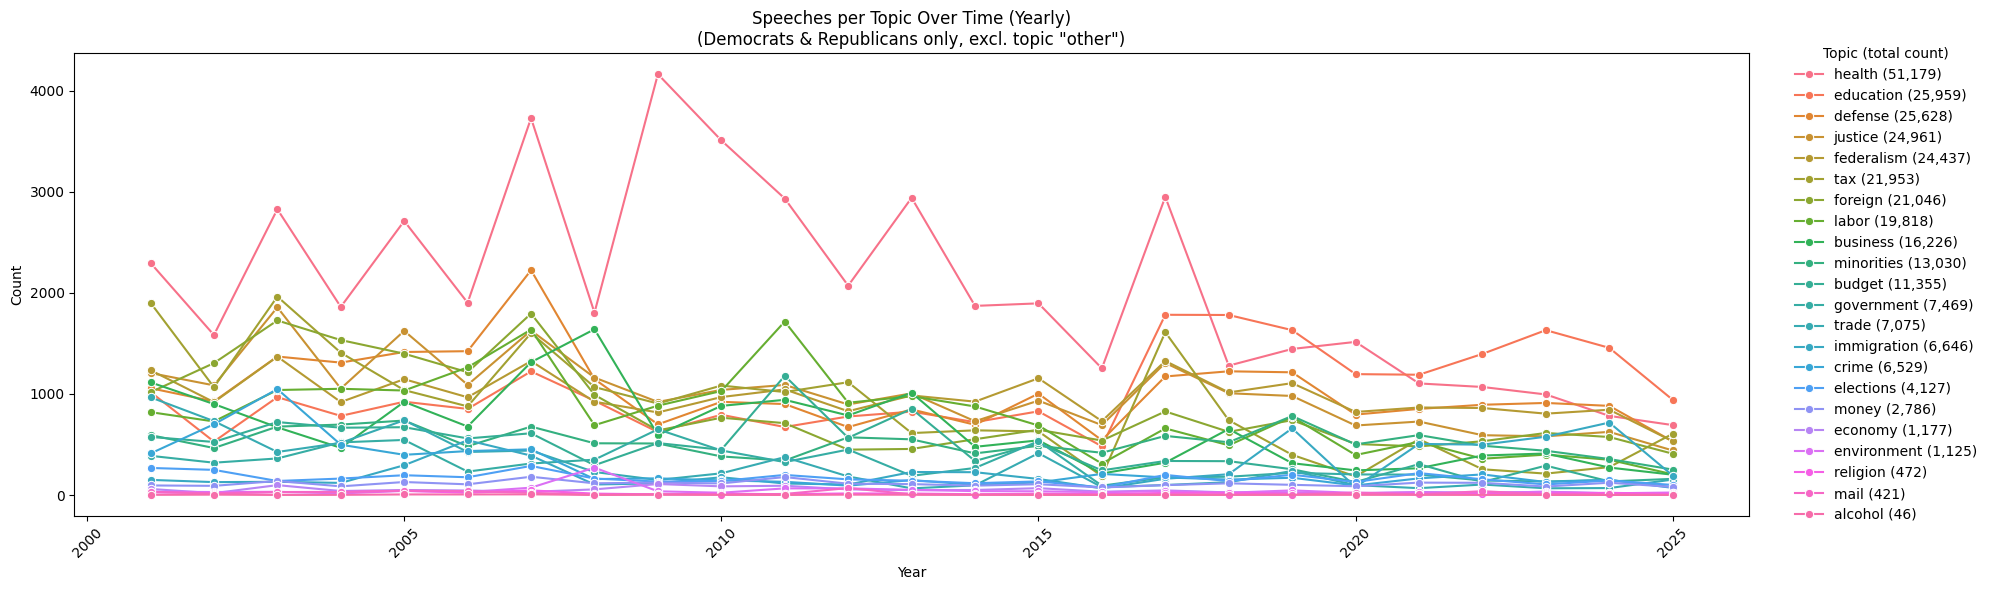

In [18]:
all_speeches['date'] = pd.to_datetime(all_speeches['date'], errors='coerce')
all_speeches['year'] = all_speeches['date'].dt.year

party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
keep_party = party_norm.isin([
    'd', 'democrat', 'democrats', 'democratic',
    'r', 'republican', 'republicans'
])
df = all_speeches[keep_party].copy()

topic_norm = df['topic'].astype(str).str.strip()
df = df[topic_norm.str.lower() != 'other'].copy()
df['topic'] = topic_norm.fillna('Unknown')

topic_year = (
    df.dropna(subset=['year'])
      .groupby(['year', 'topic'])
      .size()
      .reset_index(name='count')
      .sort_values(['year', 'topic'])
)

topic_totals = (
    topic_year.groupby('topic')['count']
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(20, 6))
ax = sns.lineplot(
    data=topic_year,
    x='year', y='count',
    hue='topic',
    hue_order=list(topic_totals.index),
    marker='o',
    legend=True
)
plt.title('Speeches per Topic Over Time (Yearly)\n(Democrats & Republicans only, excl. topic "other")')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Build legend labels with totals
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"{lab} ({topic_totals.get(lab, 0):,})" for lab in labels if lab != 'topic']
handles = [h for (h, lab) in zip(handles, labels) if lab != 'topic']

leg = ax.legend(
    handles, new_labels,
    title="Topic (total count)",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=False
)

plt.tight_layout()
plt.show()

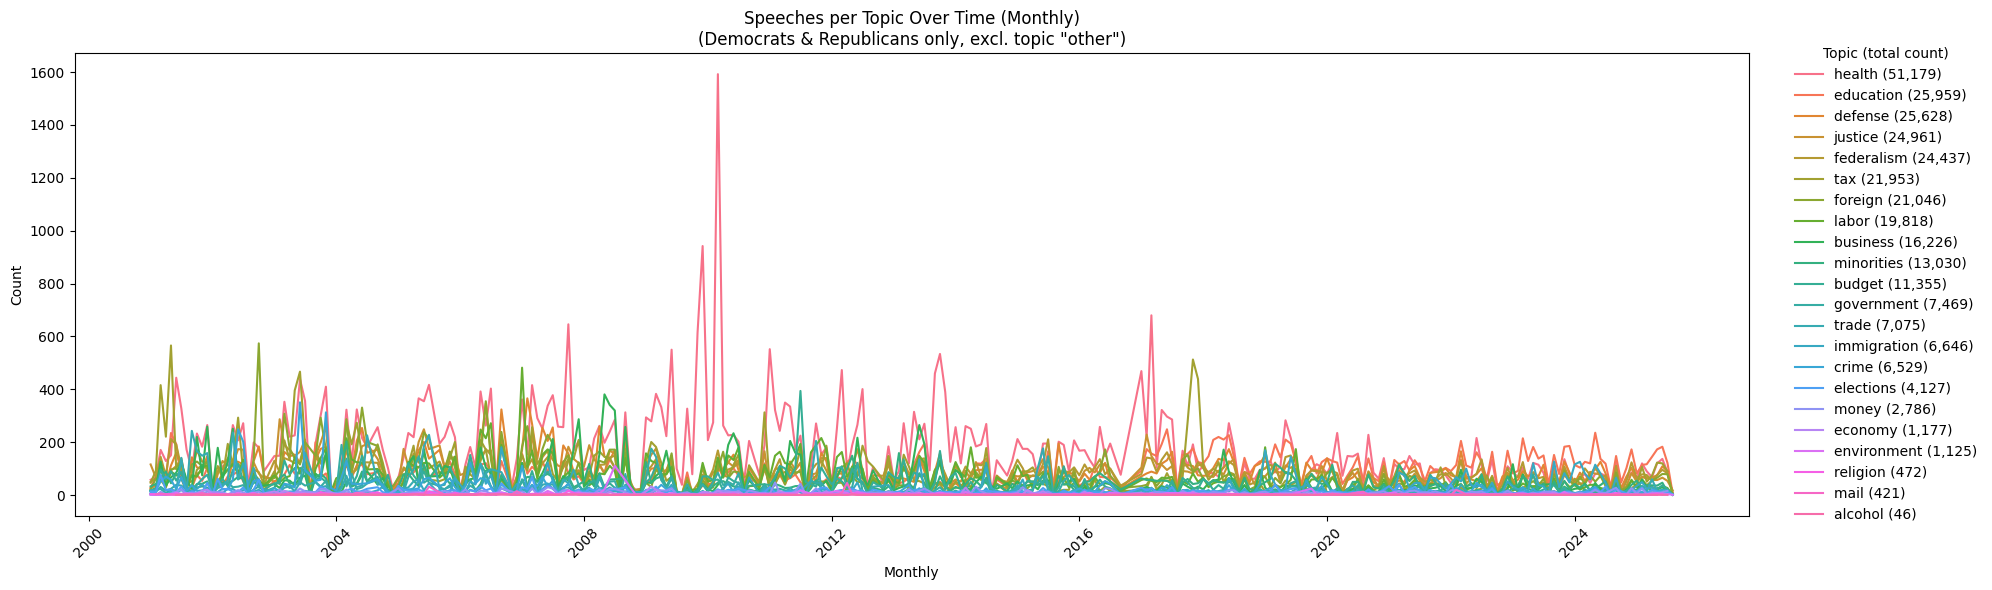

In [19]:
all_speeches['date'] = pd.to_datetime(all_speeches['date'], errors='coerce')
all_speeches['month'] = all_speeches['date'].dt.to_period('M').dt.to_timestamp()

party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
keep_party = party_norm.isin([
    'd','democrat','democrats','democratic',
    'r','republican','republicans'
])
df = all_speeches[keep_party].copy()

topic_norm = df['topic'].astype(str).str.strip()
df = df[topic_norm.str.lower() != 'other'].copy()
df['topic'] = topic_norm.fillna('Unknown')

topic_month = (
    df.dropna(subset=['month'])
      .groupby(['month','topic']).size().reset_index(name='count')
      .sort_values(['month','topic'])
)

topic_totals = (
    topic_month.groupby('topic')['count']
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(20,6))
ax = sns.lineplot(
    data=topic_month,
    x='month', y='count',
    hue='topic',
    hue_order=list(topic_totals.index),
    legend=True
)
plt.title('Speeches per Topic Over Time (Monthly)\n(Democrats & Republicans only, excl. topic "other")')
plt.xlabel('Monthly'); plt.ylabel('Count')
plt.xticks(rotation=45)

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"{lab} ({topic_totals.get(lab, 0):,})" for lab in labels if lab != 'topic']
handles = [h for (h, lab) in zip(handles, labels) if lab != 'topic']

leg = ax.legend(
    handles, new_labels,
    title="Topic (total count)",
    bbox_to_anchor=(1.02, 0.5), loc="center left",
    frameon=False
)

plt.tight_layout()
plt.show()


## 3.6 Speech Length and Speaker Characteristics
<a name="36-speech-length-and-speaker-characteristics"></a>

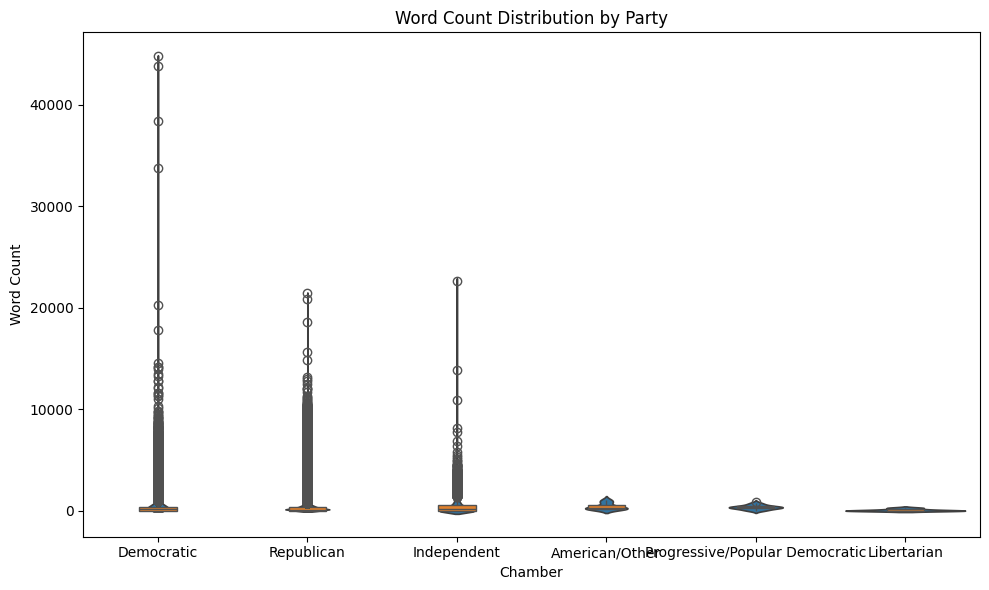

In [20]:
plt.figure(figsize=(10,6))
sns.violinplot(data=all_speeches, x='party', y='word_count', inner=None)
sns.boxplot(data=all_speeches, x='party', y='word_count', width=0.25, showcaps=False, boxprops={'zorder':2})
plt.title('Word Count Distribution by Party')
plt.xlabel('Chamber'); plt.ylabel('Word Count')
plt.tight_layout()
plt.show()


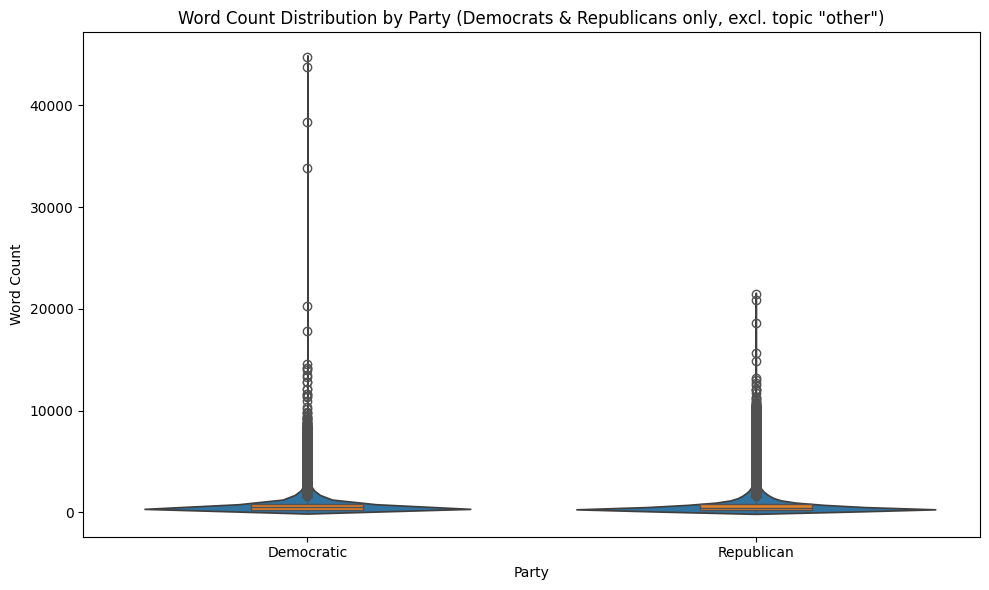

In [21]:
party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
keep_party = party_norm.isin([
    'd','democrat','democrats','democratic',
    'r','republican','republicans'
])
df = all_speeches[keep_party].copy()

topic_norm = df['topic'].astype(str).str.strip()
df = df[topic_norm.str.lower() != 'other'].copy()

df['party_clean'] = party_norm[keep_party].map({
    'd':'Democratic','democrat':'Democratic','democrats':'Democratic','democratic':'Democratic',
    'r':'Republican','republican':'Republican','republicans':'Republican'
})

plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='party_clean', y='word_count', order=['Democratic','Republican'], inner=None)
sns.boxplot(data=df, x='party_clean', y='word_count',
            order=['Democratic','Republican'], width=0.25, showcaps=False, boxprops={'zorder':2})

plt.title('Word Count Distribution by Party (Democrats & Republicans only, excl. topic "other")')
plt.xlabel('Party')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()


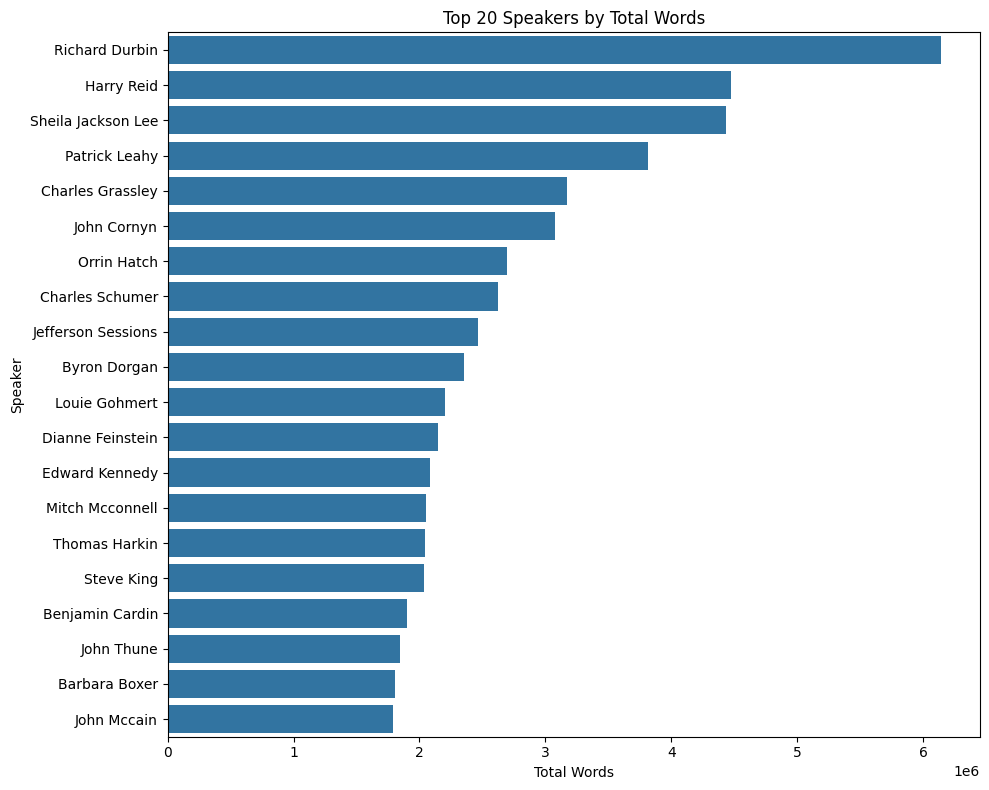

In [22]:
top_speakers = (all_speeches.groupby('speaker')['word_count']
                .sum().sort_values(ascending=False).head(20))
plt.figure(figsize=(10,8))
sns.barplot(x=top_speakers.values, y=top_speakers.index)
plt.title('Top 20 Speakers by Total Words')
plt.xlabel('Total Words'); plt.ylabel('Speaker')
plt.tight_layout()
plt.show()


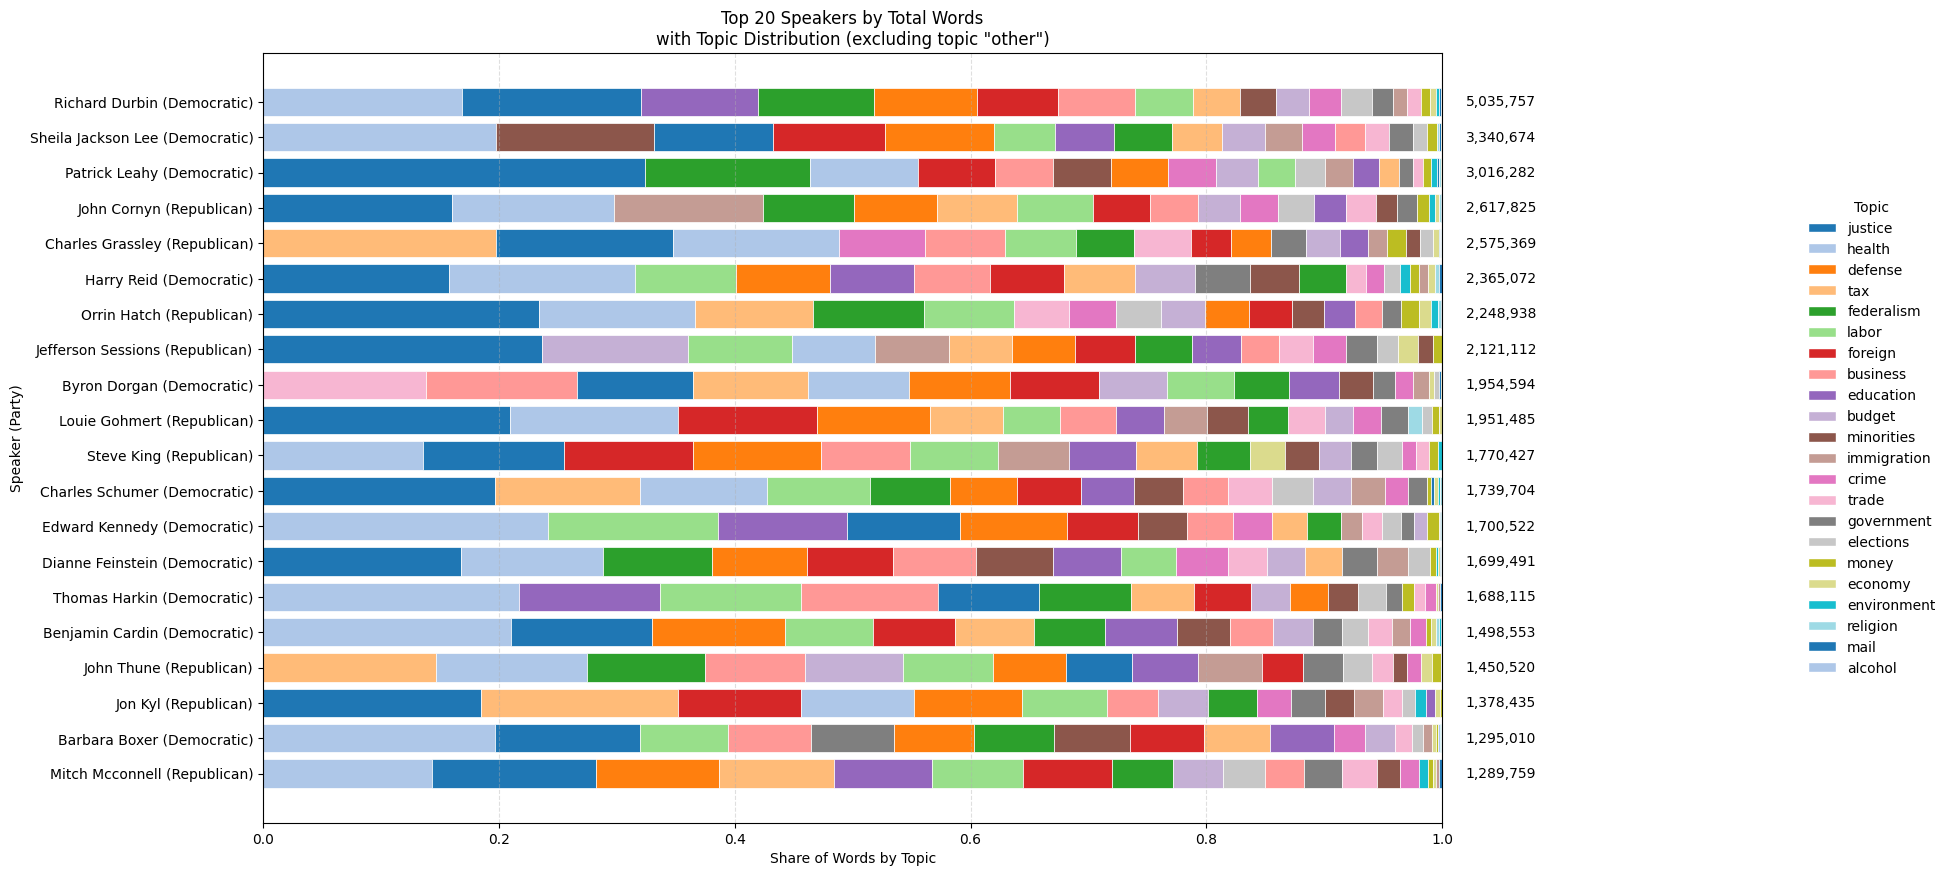

In [23]:
df = all_speeches.copy()

topic_norm = df['topic'].astype(str).str.strip()
df = df[topic_norm.str.lower() != 'other'].copy()
df['topic'] = topic_norm.fillna('Unknown')

party_norm = df['party'].astype(str).str.strip().str.lower()
party_map = {
    'd':'Democratic','democrat':'Democratic','democrats':'Democratic','democratic':'Democratic',
    'r':'Republican','republican':'Republican','republicans':'Republican',
    'i':'Independent','independent':'Independent',
    'libertarian':'Libertarian'
}
df['party_clean'] = party_norm.map(party_map).fillna(df['party'].astype(str))

speaker_topic = (
    df.groupby(['speaker','topic'], as_index=False)['word_count']
      .sum().rename(columns={'word_count':'words'})
)

speaker_totals = speaker_topic.groupby('speaker', as_index=False)['words'].sum()
top_speakers = (speaker_totals.sort_values('words', ascending=False)
                              .head(20)
                              .set_index('speaker')['words'])
speaker_order = top_speakers.index.tolist()

party_totals = (
    df.groupby(['speaker','party_clean'], as_index=False)['word_count'].sum()
      .rename(columns={'word_count':'words'})
      .sort_values(['speaker','words'], ascending=[True, False])
)
dominant_party = (party_totals.drop_duplicates('speaker')
                               .set_index('speaker')['party_clean']
                               .to_dict())

speaker_topic_top = speaker_topic[speaker_topic['speaker'].isin(speaker_order)].copy()

wide = (speaker_topic_top
        .pivot_table(index='speaker', columns='topic', values='words', aggfunc='sum', fill_value=0)
        .reindex(index=speaker_order))

prop = wide.div(wide.sum(axis=1), axis=0).fillna(0)
totals = wide.sum(axis=1)

topic_overall_order = wide.sum(axis=0).sort_values(ascending=False).index.tolist()

cmap = plt.get_cmap('tab20')
colors = {topic: cmap(i % 20) for i, topic in enumerate(topic_overall_order)}

fig, ax = plt.subplots(figsize=(18, 10))

y_positions = np.arange(len(speaker_order))
bar_height = 0.8

for i, speaker in enumerate(speaker_order):
    row = prop.loc[speaker]
    row_nonzero = row[row > 0].sort_values(ascending=False)
    left = 0.0
    for topic, frac in row_nonzero.items():
        ax.barh(i, frac, left=left, height=bar_height,
                color=colors.get(topic, 'grey'), edgecolor='white', linewidth=0.5)
        left += frac
    ax.text(1.02, i, f"{int(totals.loc[speaker]):,}",
            va='center', ha='left',
            transform=ax.get_yaxis_transform(), clip_on=False)

yticklabels = [f"{sp} ({dominant_party.get(sp, '?')})" for sp in speaker_order]
ax.set_yticks(y_positions)
ax.set_yticklabels(yticklabels)

ax.set_xlim(0, 1)
ax.set_xlabel('Share of Words by Topic')
ax.set_ylabel('Speaker (Party)')
ax.set_title('Top 20 Speakers by Total Words\nwith Topic Distribution (excluding topic "other")')
ax.grid(True, axis='x', linestyle='--', alpha=0.4)

ax.invert_yaxis()

legend_patches = [Patch(facecolor=colors[t], edgecolor='white', label=t) for t in topic_overall_order]
ax.legend(handles=legend_patches, title='Topic',
          bbox_to_anchor=(1.30, 0.5), loc='center left', frameon=False)

fig.subplots_adjust(right=0.78)

plt.show()


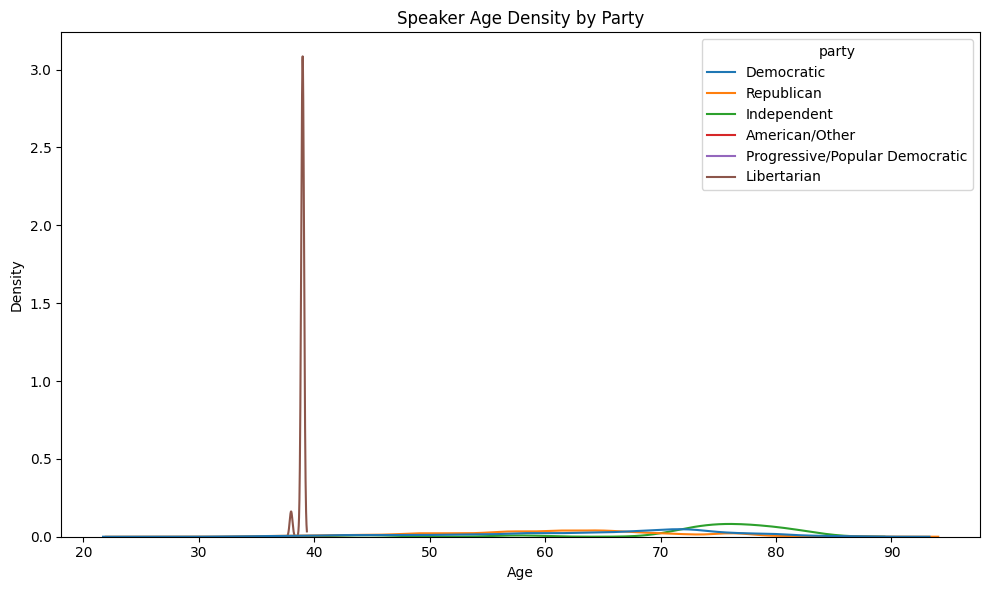

In [24]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=all_speeches, x='speaker_age', hue='party', common_norm=False)
plt.title('Speaker Age Density by Party')
plt.xlabel('Age'); plt.ylabel('Density')
plt.tight_layout()
plt.show()


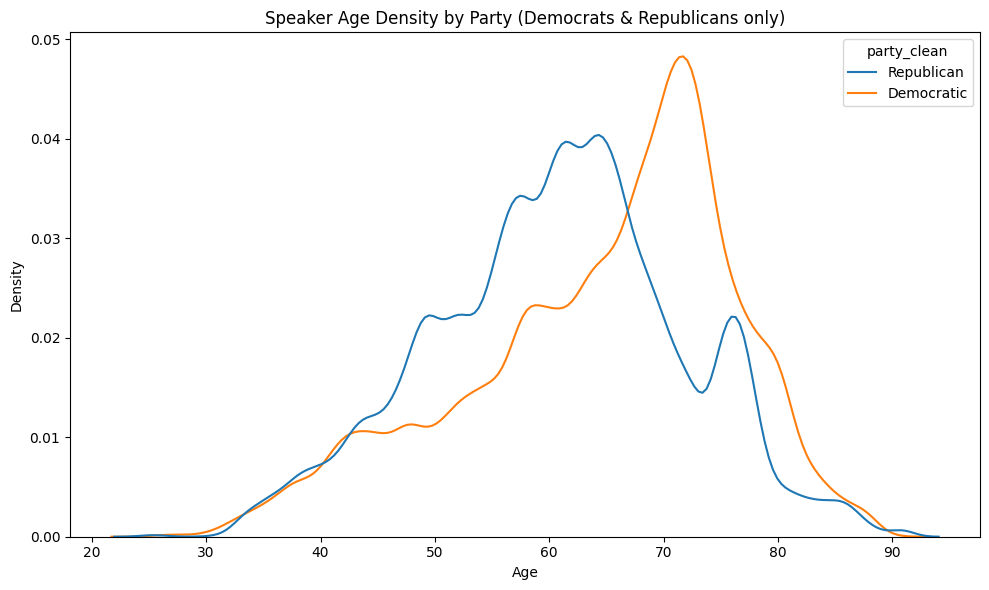

In [25]:
party_norm = all_speeches['party'].astype(str).str.strip().str.lower()
keep_party = party_norm.isin([
    'd','democrat','democrats','democratic',
    'r','republican','republicans'
])

df = all_speeches[keep_party].copy()
df['party_clean'] = party_norm[keep_party].map({
    'd':'Democratic','democrat':'Democratic','democrats':'Democratic','democratic':'Democratic',
    'r':'Republican','republican':'Republican','republicans':'Republican'
})

df['speaker_age'] = pd.to_numeric(df['speaker_age'], errors='coerce')
df = df.dropna(subset=['speaker_age'])

plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x='speaker_age', hue='party_clean', common_norm=False)
plt.title('Speaker Age Density by Party (Democrats & Republicans only)')
plt.xlabel('Age'); plt.ylabel('Density')
plt.tight_layout()
plt.show()


# Section 4: Modeling Preparation – Toward a Polarization Metric
<a name="section-4-modeling-preparation--toward-a-polarization-metric"></a>


In [26]:
party_norm = (
    all_speeches['party']
    .astype(str)
    .str.strip()
    .str.lower()
)

topic_norm = (
    all_speeches['topic']
    .astype(str)
    .str.strip()
    .str.lower()
)

all_speeches_filtered = (
    all_speeches
    .loc[
        party_norm.isin(['republican', 'democratic']) &
        (topic_norm != 'other')
    ]
    .reset_index(drop=True)
)

print(f"Filtered dataset: {len(all_speeches_filtered):,} rows (from {len(all_speeches):,} total).")
all_speeches_filtered


Filtered dataset: 293,465 rows (from 984,929 total).


,speech_id,speech,chamber,date,number_within_file,speaker,state,gender,line_start,line_end,...,party,district,nonvoting,congress,topic,speaker_age,source_file,state_abbrev,year,month
0,1070000077,Mr. President. 213 years ago. the Framers of t...,Senate,2001-01-03,77,Thomas Daschle,South Dakota,Male,1945.0,2186.0,...,Democratic,NaN,voting,107,crime,NaN,speeches_107_clean.csv,SD,2001,2001-01-01
1,1070000078,Mr. President. before the majority leader leav...,Senate,2001-01-03,78,Harry Reid,Nevada,Male,2387.0,2443.0,...,Democratic,NaN,voting,107,health,NaN,speeches_107_clean.csv,NV,2001,2001-01-01
2,1070000087,Mr. President. today we saw new Members of the...,Senate,2001-01-03,87,J. Cleland,Georgia,Male,2512.0,2536.0,...,Democratic,NaN,voting,107,federalism,NaN,speeches_107_clean.csv,GA,2001,2001-01-01
3,1070000094,Mr. President. I rise to recognize the service...,Senate,2001-01-03,94,J. Thurmond,South Carolina,Male,2620.0,2723.0,...,Republican,NaN,voting,107,federalism,NaN,speeches_107_clean.csv,SC,2001,2001-01-01
4,1070000112,I guess I really should not hammer it down whi...,House,2001-01-03,112,J. Hastert,Illinois,Male,5681.0,6052.0,...,Republican,14.0,voting,107,education,NaN,speeches_107_clean.csv,IL,2001,2001-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293460,CREC-2025-08-01-pt1-PgS5189_156,"Mr. TUBERVILLE. Mr. President, as a son of a W...",Senate,2025-08-01,39,Tommy Tuberville,Alabama,Male,NaN,NaN,...,Republican,NaN,False,119,defense,70.0,speeches_119_clean.csv,AL,2025,2025-08-01
293461,CREC-2025-08-01-pt1-PgS5189_172,"Mr. HOEVEN. Mr. President, this amendment woul...",Senate,2025-08-01,45,John Hoeven,North Dakota,Male,NaN,NaN,...,Republican,NaN,False,119,justice,68.0,speeches_119_clean.csv,ND,2025,2025-08-01
293462,CREC-2025-08-01-pt1-PgS5189_174,Mrs. SHAHEEN. I want to agree with Chairman Ho...,Senate,2025-08-01,46,Jeanne Shaheen,New Hampshire,Female,NaN,NaN,...,Democratic,NaN,False,119,business,78.0,speeches_119_clean.csv,NH,2025,2025-08-01
293463,CREC-2025-08-01-pt1-PgS5189_190,"Mr. SCOTT of Florida. Mr. President, first and...",Senate,2025-08-01,51,Rick Scott,Florida,Male,NaN,NaN,...,Republican,NaN,False,119,budget,72.0,speeches_119_clean.csv,FL,2025,2025-08-01


## 4.1 Exporting the Modeling Dataset
<a name="41-exporting-the-modeling-dataset"></a>

In [27]:
#filtered_path = os.path.join(folder, 'all_speeches_filtered_backup.csv')
#all_speeches_filtered.to_csv(filtered_path, index=False)
#print(f"Saved filtered dataset to: {filtered_path}")
#all_speeches_filtered